In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# 4. Comparação por cor

## 4.1 Introdução

### 4.1.1 Algoritmo - Pseudo código

Sabendo que existem pílulas com duas cores, o algoritmo de comparação divide as imagens no meio e busca a menor proximidade entre os dalos das imagens

* **Entrada:** imagem, imagens_banco
* **Saída:** imagens mais próximas conforme o critério de comparação

```python
# Pseudo código
def comparar(imagem, imagens_banco):
    resultado = []

    for imagem_banco in imagens_banco:

        imagem_left, imagem_right = split(imagem - cor_cinza_de_fundo)
        imagem_banco_left, imagem_banco_right = split(imagem_banco - cor_cinza_de_fundo)

        distancia_mais_proxima = min(
            comparar_cores(imagem_left, imagem_banco_left),
            comparar_cores(imagem_left, imagem_banco_right),
            comparar_cores(imagem_right, imagem_banco_left),
            comparar_cores(imagem_right, imagem_banco_right),
        )

        resultado.append(tuple(imagem_banco, distancia_mais_proxima))

    return resultado.order_by("distancia_mais_proxima")
```

Para pegar as n primeiras

```python
comparar(imagem, imagens_banco)[0:n]
```

### 4.1.2 Tipos de comparação de cores

``comparar_cores()`` foi implementado como:
 * 4.2 Comparação RGB
 * 4.3 Comparação H (SV são desconsiderados)
 * 4.4 Comparação $L^*a^*b^*$

## 4.2 Comparação RGB

A comparação entre imagens através dos canais RGB é através da distância euclidiana entre as cores:

$$euclidian\_distance = \sqrt{ (r1-r2)^2 + (g1-g2)^2 + (b1-b2)^2 }$$

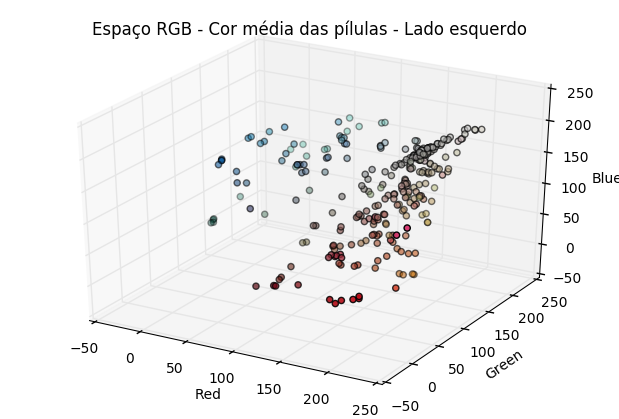

In [2]:
import pandas as pd
import util.plot as plot_utils

path = 'resultados/cache/table_means.csv'
pilulas = pd.read_csv(path)

cores_lado_esquerdo = pilulas[['mean_left_r', 'mean_left_g', 'mean_left_b']]
cores_lado_esquerdo.columns = ['r', 'g', 'b']

plot_utils.plot_cubo_rgb(cores_lado_esquerdo, 'Espaço RGB - Cor média das pílulas - Lado esquerdo')

### 4.2.1 Teste

Observação: A cor em destaque é a cor média da imagem toda


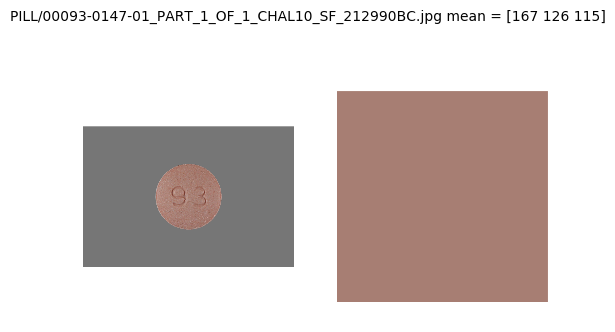

In [3]:
import util.show_images as show_images

imagem = 'PILL/00093-0147-01_PART_1_OF_1_CHAL10_SF_212990BC.jpg'
cinza = [118, 118, 118]

print("Observação: A cor em destaque é a cor média da imagem toda")
show_images.show_image_color_mean(imagem, cinza)

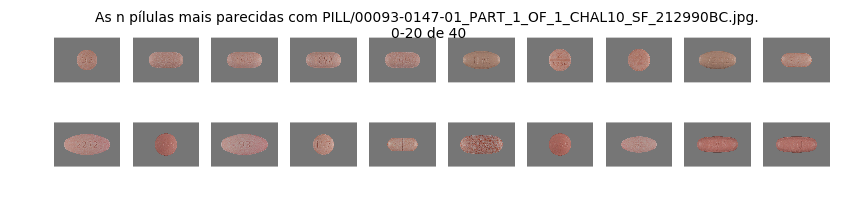

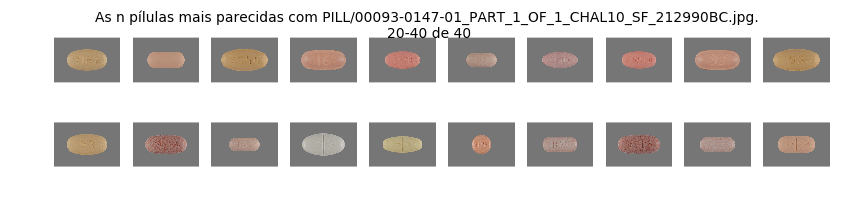

In [4]:
from image_similarity.color_similarity_processor import RGBColorSimilarityProcessor

tabela_cores_media = pd.read_csv('resultados/cache/table_means.csv')

rgb_processador = RGBColorSimilarityProcessor(tabela_cores_media, cinza)
distancias = rgb_processador.process(imagem)

show_images.show(distancias['path'][0:40], title='As n pílulas mais parecidas com ' + imagem)

## 4.3 Comparação H (SV são desconsiderados)

A comparação entre imagens através do H considera somente a cor HUE. Ou seja, considera somente a $matiz$.

$$hue\_distance = min(\bigl|h1-h0 \bigr|, 360 - \bigl| h1-h0 \bigr| )$$

No nosso caso, os valores de H estão normalizados para o intervalo $[0..1]$

Referência: http://stackoverflow.com/a/35114586/1524997

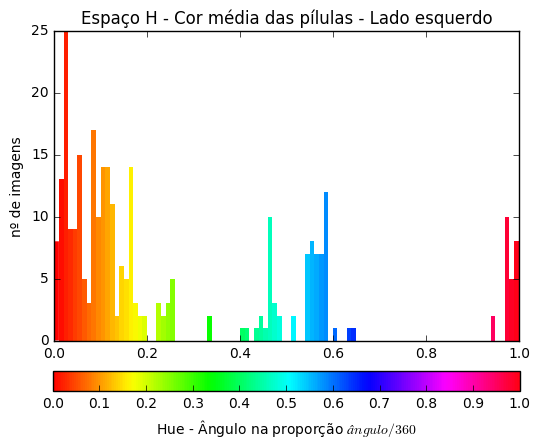

In [5]:
import numpy as np
import colorsys

rgb_to_h = lambda color: colorsys.rgb_to_hsv(color[0]/256, color[1]/256, color[2]/256)[0]

cores_lado_esquerdo = pilulas[['mean_left_r', 'mean_left_g', 'mean_left_b']].copy()
cores_lado_esquerdo['h'] = cores_lado_esquerdo[['mean_left_r', 'mean_left_g', 'mean_left_b']].apply(rgb_to_h, axis=1)


plot_utils.plot_h_bar(cores_lado_esquerdo['h'], 'Espaço H - Cor média das pílulas - Lado esquerdo')

### 4.3.1 Testes

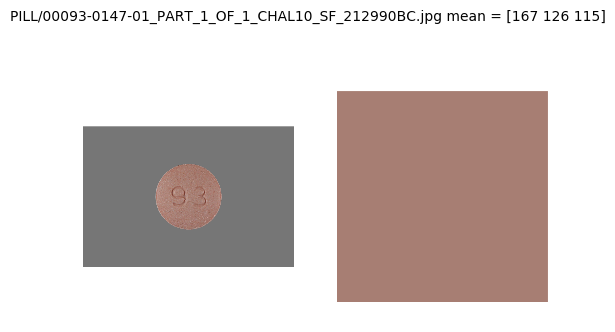

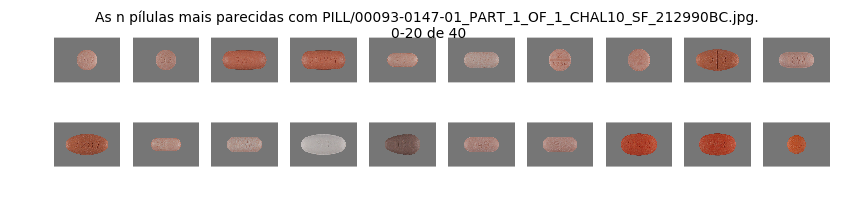

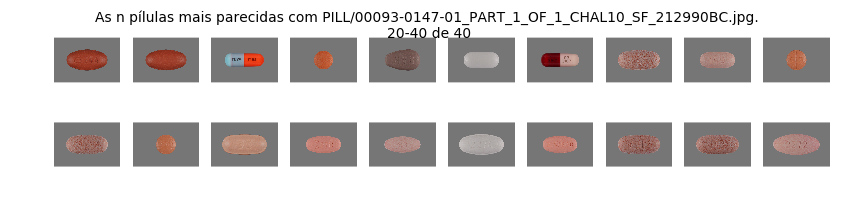

In [6]:
from image_similarity.color_similarity_processor import HSVColorSimilarityProcessor

hsv_processador = HSVColorSimilarityProcessor(tabela_cores_media, cinza)

distancias = hsv_processador.process(imagem)
show_images.show_image_color_mean(imagem, cinza)
show_images.show(distancias['path'][0:40], title='As n pílulas mais parecidas com ' + imagem)

## 4.4 Comparação $L^*a^*b^*$


### 4.4.1 Sobre

    "O espaço de cor L*a*b*, também conhecido como espaço de cor CIELAB é atualmente o mais popular dos espaços de cores uniformes usados para avaliar as cores. Esse espaço de cor é amplamente utilizado pois correlaciona consistentemente os valores de cor com a percepção visual. Indústrias como as de plástico, tintas, impressão, alimentos e têxtil, além de universidades, utilizam este espaço para identificar, comunicar e avaliar os atributos da cor além das inconsistências ou desvios de uma cor padrão.
    
    [...] L*a*b* foi criado após a teoria de cores opostas, onde duas cores não podem ser verdes e vermelhas ao mesmo tempo, ou amarelas e azuis ao mesmo tempo.  Como mostrado abaixo, o L* indica a luminosidade e o a* e b*, são as coordenadas cromáticas.

    - L* = Luminosidade
    - a* = coordenada vermelho/verde (+a indica vermleho e –a indica verde)
    - b* = coordenada amarelo / azul (+b indica amarelo e –b indica azul)"

$-$ 2006-2017 Konica Minolta Sensing Americas, Inc.

### 4.4.2 Método de comparação

Os métodos implementados em $skimage$ para comparar cores $L^*a^*b^*$ são:

 * **deltaE_cie76**: Distância euclidiana;
 * **deltaE_ciede94**: Diferença de cores de acordo com o padrão CIEDE 94;
 * **deltaE_ciede2000**: Diferença de cores de acordo com o padrão CIEDE 2000
 "The perceptual calibration is largely based on experience with automotive paint on smooth surfaces."

O utilizado foi a distância euclidiana.

 * http://www.color-image.com/2011/10/the-proper-notation-for-the-cielab-color-space/
 * http://sensing.konicaminolta.com.br/2013/11/entendendo-o-espaco-de-cor-lab/

### 4.4.3 Testes

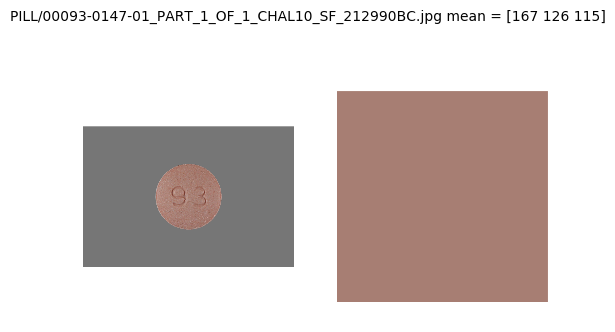

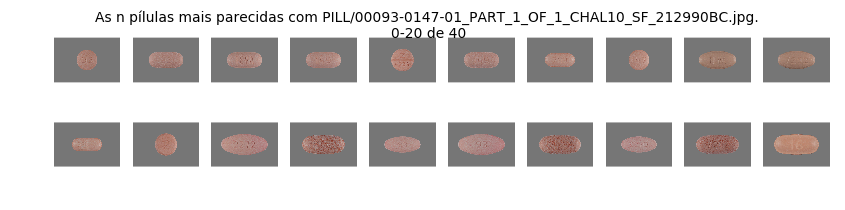

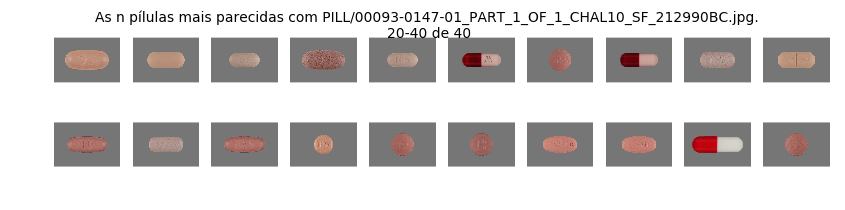

In [7]:
from image_similarity.color_similarity_processor import CIELABColorSimilarityProcessor

lab_processador = CIELABColorSimilarityProcessor(tabela_cores_media, cinza)

distancias = lab_processador.process(imagem)
show_images.show_image_color_mean(imagem, cinza)
show_images.show(distancias['path'][0:40], title='As n pílulas mais parecidas com ' + imagem)

# OUTROS TESTES

In [8]:
import glob
from start import ImagesProcessorByColor

In [9]:
pilulas_path = glob.glob("PILL/*")
cinza = [118, 118, 118]

pilulas = [
    'PILL/00093-0147-01_PART_1_OF_1_CHAL10_SF_212990BC.jpg',  # ~ vermelho
    'PILL/00085-1322-01_PART_1_OF_1_CHAL10_SF_CF07E78F.jpg',  # ~ azul
    'PILL/00074-9189-90_PART_1_OF_1_CHAL10_SF_DF1DEFBF.jpg',  # ~ azul e amarelo
    'PILL/00093-0757-01_PART_1_OF_1_CHAL10_SB_AC2B561A.jpg',  # ~ verde
    'PILL/00093-0321-01_PART_1_OF_1_CHAL10_SB_902B486A.jpg',  # ~laranja'
]

In [10]:
processador = ImagesProcessorByColor(pilulas_path, cinza, "resultados/")

for pilula in pilulas:
    processador.process(pilula)

resultados/RGBColorSimilarityProcessor - 00093-0147-01_PART_1_OF_1_CHAL10_SF_212990BC.jpg.csv
resultados/HSVColorSimilarityProcessor - 00093-0147-01_PART_1_OF_1_CHAL10_SF_212990BC.jpg.csv
resultados/CIELABColorSimilarityProcessor - 00093-0147-01_PART_1_OF_1_CHAL10_SF_212990BC.jpg.csv
resultados/RGBColorSimilarityProcessor - 00085-1322-01_PART_1_OF_1_CHAL10_SF_CF07E78F.jpg.csv
resultados/HSVColorSimilarityProcessor - 00085-1322-01_PART_1_OF_1_CHAL10_SF_CF07E78F.jpg.csv
resultados/CIELABColorSimilarityProcessor - 00085-1322-01_PART_1_OF_1_CHAL10_SF_CF07E78F.jpg.csv
resultados/RGBColorSimilarityProcessor - 00074-9189-90_PART_1_OF_1_CHAL10_SF_DF1DEFBF.jpg.csv
resultados/HSVColorSimilarityProcessor - 00074-9189-90_PART_1_OF_1_CHAL10_SF_DF1DEFBF.jpg.csv
resultados/CIELABColorSimilarityProcessor - 00074-9189-90_PART_1_OF_1_CHAL10_SF_DF1DEFBF.jpg.csv
resultados/RGBColorSimilarityProcessor - 00093-0757-01_PART_1_OF_1_CHAL10_SB_AC2B561A.jpg.csv
resultados/HSVColorSimilarityProcessor - 00093-0757